In [1]:
# annotations for code readability
import typing as tp
import chex

# data manipulation and split
import polars as pl
from sklearn.model_selection import train_test_split

# nn
import jax
from jax import numpy as jnp
from flax import nnx
import optax

from utils import (
    MLP,
    _init_metrics_hisory,
    _init_model,
    plot_metrics,
    batch
)

In [2]:
df = pl.read_csv("./data/sonar.csv")
df.head()

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,Class
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64
0.02,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,0.1609,0.1582,0.2238,0.0645,0.066,0.2273,0.31,0.2999,0.5078,0.4797,0.5783,0.5071,0.4328,0.555,0.6711,0.6415,0.7104,0.808,0.6791,0.3857,0.1307,0.2604,0.5121,0.7547,0.8537,0.8507,0.6692,0.6097,0.4943,0.2744,0.051,0.2834,0.2825,0.4256,0.2641,0.1386,0.1051,0.1343,0.0383,0.0324,0.0232,0.0027,0.0065,0.0159,0.0072,0.0167,0.018,0.0084,0.009,0.0032,1
0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,0.4918,0.6552,0.6919,0.7797,0.7464,0.9444,1.0,0.8874,0.8024,0.7818,0.5212,0.4052,0.3957,0.3914,0.325,0.32,0.3271,0.2767,0.4423,0.2028,0.3788,0.2947,0.1984,0.2341,0.1306,0.4182,0.3835,0.1057,0.184,0.197,0.1674,0.0583,0.1401,0.1628,0.0621,0.0203,0.053,0.0742,0.0409,0.0061,0.0125,0.0084,0.0089,0.0048,0.0094,0.0191,0.014,0.0049,0.0052,0.0044,1
0.0262,0.0582,0.1099,0.1083,0.0974,0.228,0.2431,0.3771,0.5598,0.6194,0.6333,0.706,0.5544,0.532,0.6479,0.6931,0.6759,0.7551,0.8929,0.8619,0.7974,0.6737,0.4293,0.3648,0.5331,0.2413,0.507,0.8533,0.6036,0.8514,0.8512,0.5045,0.1862,0.2709,0.4232,0.3043,0.6116,0.6756,0.5375,0.4719,0.4647,0.2587,0.2129,0.2222,0.2111,0.0176,0.1348,0.0744,0.013,0.0106,0.0033,0.0232,0.0166,0.0095,0.018,0.0244,0.0316,0.0164,0.0095,0.0078,1
0.01,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,0.0881,0.1992,0.0184,0.2261,0.1729,0.2131,0.0693,0.2281,0.406,0.3973,0.2741,0.369,0.5556,0.4846,0.314,0.5334,0.5256,0.252,0.209,0.3559,0.626,0.734,0.612,0.3497,0.3953,0.3012,0.5408,0.8814,0.9857,0.9167,0.6121,0.5006,0.321,0.3202,0.4295,0.3654,0.2655,0.1576,0.0681,0.0294,0.0241,0.0121,0.0036,0.015,0.0085,0.0073,0.005,0.0044,0.004,0.0117,1
0.0762,0.0666,0.0481,0.0394,0.059,0.0649,0.1209,0.2467,0.3564,0.4459,0.4152,0.3952,0.4256,0.4135,0.4528,0.5326,0.7306,0.6193,0.2032,0.4636,0.4148,0.4292,0.573,0.5399,0.3161,0.2285,0.6995,1.0,0.7262,0.4724,0.5103,0.5459,0.2881,0.0981,0.1951,0.4181,0.4604,0.3217,0.2828,0.243,0.1979,0.2444,0.1847,0.0841,0.0692,0.0528,0.0357,0.0085,0.023,0.0046,0.0156,0.0031,0.0054,0.0105,0.011,0.0015,0.0072,0.0048,0.0107,0.0094,1


In [3]:
assert df.null_count().sum_horizontal()[0] == 0
df.describe()

statistic,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,Class
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0,208.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.029164,0.038437,0.043832,0.053892,0.075202,0.10457,0.121747,0.134799,0.178003,0.208259,0.236013,0.250221,0.273305,0.296568,0.320201,0.378487,0.415983,0.452318,0.504812,0.563047,0.60906,0.624275,0.646975,0.672654,0.675424,0.699866,0.702155,0.694024,0.642074,0.580928,0.504475,0.43904,0.41722,0.403233,0.392571,0.384848,0.363807,0.339657,0.3258,0.311207,0.289252,0.278293,0.246542,0.214075,0.197232,0.160631,0.122453,0.091424,0.051929,0.020424,0.016069,0.01342,0.010709,0.010941,0.00929,0.008222,0.00782,0.007949,0.007941,0.006507,0.466346
"""std""",0.022991,0.03296,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,0.132705,0.140072,0.140962,0.164474,0.205427,0.23265,0.263677,0.261529,0.257988,0.262653,0.257818,0.255883,0.250175,0.239116,0.244926,0.237228,0.245657,0.237189,0.24025,0.220749,0.213992,0.213237,0.206513,0.231242,0.259132,0.264121,0.239912,0.212973,0.199075,0.178662,0.171111,0.168728,0.138993,0.133291,0.151628,0.133938,0.086953,0.062417,0.035954,0.013665,0.012008,0.009634,0.00706,0.007301,0.007088,0.005736,0.005785,0.00647,0.006181,0.005031,0.50007
"""min""",0.0015,0.0006,0.0015,0.0058,0.0067,0.0102,0.0033,0.0055,0.0075,0.0113,0.0289,0.0236,0.0184,0.0273,0.0031,0.0162,0.0349,0.0375,0.0494,0.0656,0.0512,0.0219,0.0563,0.0239,0.024,0.0921,0.0481,0.0284,0.0144,0.0613,0.0482,0.0404,0.0477,0.0212,0.0223,0.008,0.0351,0.0383,0.0371,0.0117,0.036,0.0056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0008,0.0005,0.001,0.0006,0.0004,0.0003,0.0003,0.0001,0.0006,0.0
"""25%""",0.0134,0.0165,0.019,0.0244,0.0384,0.0671,0.0812,0.0805,0.0973,0.1114,0.1303,0.1335,0.1665,0.176,0.165,0.1967,0.2062,0.2422,0.2991,0.3508,0.4019,0.4075,0.452,0.541,0.5268,0.5448,0.534,0.5356,0.4661,0.4124,0.3485,0.2822,0.2584,0.2176,0.1802,0.1547,0.1602,0.1743,0.1755,0.187,0.1638,0.1591,0.1552,0.1269,0.0945,0.0687,0.0643,0.0453,0.0264,0.0116,0.0085,0.0073,0.0051,0.0054,0.0042,0.0044,0.0037,0.0036,0.0037,0.0031,0.0
"""50%""",0.0228,0.0308,0.0344,0.0441,0.063,0.0922,0.1083,0.1123,0.1523,0.1838,0.2251,0.2497,0.2655,0.2819,0.284,0.3075,0.31,0.3709,0.4351,0.543,0.6275,0.667,0.7007,0.7012,0.7221,0.7545,0.7539,0.7321,0.6825,0.6074,0.4906,0.4303,0.3921,0.3524,0.3147,0.3228,0.3087,0.315,0.2841,0.279,0.2605,0.2458,0.224,0.1778,0.1487,0.1216,0.1018,0.0785,0.0449,0.0179,0.014,0.0115,0.0096,0.0093,0.0075,0.0069,0.006,0.0058,0.0065,0.0053,0.0
"""75%""",0.0353,0.0478,0.0577,0.0633,0.0995,0.1341,0.1539,0.1694,0.2328,0.2684,0.3015,0.3309,0.351,0.3854,0.4528,0.5354,0.6588,0.679,0.7309,0.8092,0.8159,0.8318,0.8449,0.871,0.8729,0.8938,0.9168,0.8987,0.8519,0.7334,0.6407,0.5749,0.5555,0.5961,0.5926,0.5564,0.5144,0.4401,0.4323,0.424,0.3859,0.3834,0.324,0.2694,0.2307,0.2001,0.1541,0.1198,0.0681,0.0251,0.0208,0.0167,0.0149,0.0145,0.0121,0.0105,0.0104,0.0103,0.0103,0.0085,1.0
"""max""",0.1371,0.2339,0.3059,0.4264,0.401,0.3823,0.3729,0.459,0.6828,0.7106,0.

In [4]:
X = df.drop(pl.col("Class")).to_jax()
y = df.select(pl.col("Class")).to_jax().squeeze()

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    shuffle=True)


In [5]:
X_train.shape, X_test.shape

((156, 60), (52, 60))

In [6]:
model = MLP(input_dim=60, hidden=(180, 30, 10), output_dim=2, rngs=nnx.Rngs(42))
model 

MLP(
  nn=Sequential(
    layers=[Linear(
      kernel=Param(
        value=Array(shape=(60, 180), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(180,), dtype=float32)
      ),
      in_features=60,
      out_features=180,
      use_bias=True,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x00000222D901CDC0>,
      bias_init=<function zeros at 0x00000222C8554EE0>,
      dot_general=<function dot_general at 0x00000222C7FB8550>
    ), <PjitFunction of <function silu at 0x00000222C856A5E0>>, Linear(
      kernel=Param(
        value=Array(shape=(180, 30), dtype=float32)
      ),
      bias=Param(
        value=Array(shape=(30,), dtype=float32)
      ),
      in_features=180,
      out_features=30,
      use_bias=True,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0

In [7]:
y = model(jnp.ones(60))
y

Array([-0.06502669, -0.10491133], dtype=float32)

In [8]:
def loss_fn(model: MLP, 
            features: chex.ArrayBatched, 
            labels: chex.ArrayBatched) -> tuple[chex.ArrayBatched]:
    """Computes CE-Loss with optax. Returns loss and logits"""
    logits = model(features)
    loss = jnp.mean(
        optax.softmax_cross_entropy_with_integer_labels(
            logits=logits, labels=labels
        )
    )
    
    return loss, logits


@jax.jit
def train_step(graphdef: nnx.GraphDef, 
               state: nnx.GraphState,   
               features: chex.ArrayBatched, 
               labels: chex.ArrayBatched) -> nnx.GraphState:
    """Train for a single step."""
    model, optimizer, metrics = nnx.merge(graphdef, state)
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, features, labels)
    metrics.update(loss=loss, logits=logits, labels=labels)
    optimizer.update(grads)
    _, state = nnx.split((model, optimizer, metrics))
    return state


@jax.jit
def eval_step(graphdef: nnx.GraphDef, 
              state: nnx.GraphState,   
              features: chex.ArrayBatched,
              labels: chex.ArrayBatched) -> nnx.GraphState:
    """Eval for single step"""
    model, optimizer, metrics = nnx.merge(graphdef, state)
    loss, logits = loss_fn(model, features, labels)
    metrics.update(loss=loss, logits=logits, labels=labels)
    _, state = nnx.split((model, optimizer, metrics))
    return state    

In [9]:
def run(X_train: chex.Array,
        y_train: chex.Array,
        X_test: chex.Array,
        y_test: chex.Array,
        batch_size: int = 8,
        key: tp.Optional[chex.PRNGKey] = None,
        input_dim: int = 60,
        hidden: tp.Optional[tuple[int]] = None,
        output_dim: int = 1,
        num_epochs: int = 10) -> tuple[MLP, dict[str, chex.Array], nnx.State, nnx.State]:
    """Inits model and it's components and run train and test"""
    if key is None:
        key = jax.random.key(42)
    batch_key, model_key = jax.random.split(key)
    model_key = nnx.Rngs(model_key)
    # get model and default weights of the first layer
    model, before = _init_model(input_dim=input_dim, hidden=hidden, output_dim=output_dim, rngs=model_key)
    optimizer = nnx.Optimizer(model, optax.adamw(5e-3, 0.9))
    metrics_history = _init_metrics_hisory()
    metrics = nnx.MultiMetric(
        accuracy=nnx.metrics.Accuracy(),
        loss=nnx.metrics.Average('loss'),
    )

    for i in range(num_epochs):
        # train
        model.train()
        graphdef, state = nnx.split((model, optimizer, metrics))
        batch_key = jax.random.split(batch_key)[0]
        for X_batched, y_batched in batch(X=X_train, 
                                          y=y_train,
                                          batch_size=batch_size,
                                          key=batch_key,
                                          train=True):
            state = train_step(graphdef=graphdef,
                               state=state,
                               features=X_batched, 
                               labels=y_batched)

        # store train metrics

        # if flax >= 0.10.0
        # nnx.update((model, optimizer, metrics), state)
        
        # else
        model, optimizer, metrics = nnx.merge(graphdef, state)
        for metric, value in metrics.compute().items():     
            metrics_history[f'train_{metric}'].append(value)
        metrics.reset()

        # eval
        model.eval()
        graphdef, state = nnx.split((model, optimizer, metrics))
        for X_batched, y_batched in batch(X=X_test, 
                                          y=y_test,
                                          batch_size=batch_size,
                                          key=batch_key,
                                          train=False):
            state = eval_step(graphdef=graphdef,
                              state=state,
                              features=X_batched, 
                              labels=y_batched)
        
        # store eval metrics

        # if flax >= 0.10.0
        # nnx.update((model, optimizer, metrics), state)
        
        # else
        model, optimizer, metrics = nnx.merge(graphdef, state)
        for metric, value in metrics.compute().items():    
            metrics_history[f'test_{metric}'].append(value)
        metrics.reset() 

        print(
            f"[train] eposh: {i}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
        )
        print(
            f"[test] epoch: {i}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
        )

    # updated weights
    after = nnx.state(model)
    
    return model, metrics_history, before, after


In [10]:
_, metrics_history, before, after = run(X_train=X_train, 
                                        y_train=y_train, 
                                        X_test=X_test, 
                                        y_test=y_test,
                                        batch_size=13,
                                        key=jax.random.key(42),
                                        input_dim=X_train.shape[1], 
                                        hidden=(60,), 
                                        output_dim=2, 
                                        num_epochs=20)

[train] eposh: 0, loss: 0.7407930493354797, accuracy: 51.92307662963867
[test] epoch: 0, loss: 0.6624027490615845, accuracy: 57.69230651855469
[train] eposh: 1, loss: 0.6754912734031677, accuracy: 58.33333206176758
[test] epoch: 1, loss: 0.6451982855796814, accuracy: 57.69230651855469
[train] eposh: 2, loss: 0.6383711695671082, accuracy: 65.38461303710938
[test] epoch: 2, loss: 0.5564033389091492, accuracy: 82.69230651855469
[train] eposh: 3, loss: 0.5971398949623108, accuracy: 69.87179565429688
[test] epoch: 3, loss: 0.5033178925514221, accuracy: 86.53846740722656
[train] eposh: 4, loss: 0.5619186162948608, accuracy: 74.35897827148438
[test] epoch: 4, loss: 0.4501572549343109, accuracy: 86.53846740722656
[train] eposh: 5, loss: 0.5235675573348999, accuracy: 77.56410217285156
[test] epoch: 5, loss: 0.40099799633026123, accuracy: 88.46153259277344
[train] eposh: 6, loss: 0.5101561546325684, accuracy: 76.28205108642578
[test] epoch: 6, loss: 0.3817565441131592, accuracy: 86.5384674072265

accuracy
loss


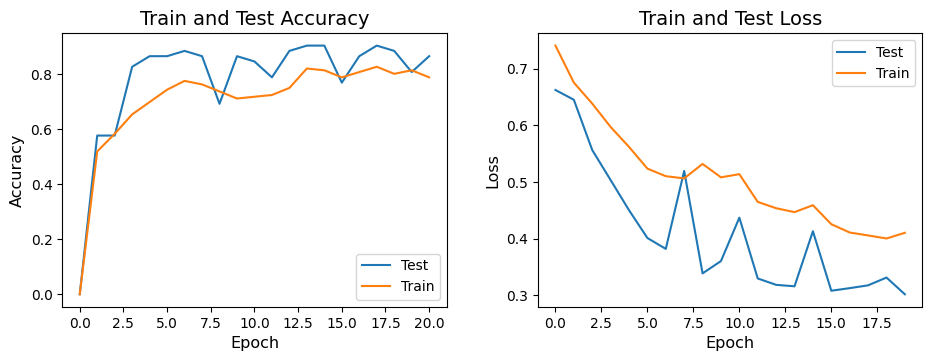

In [11]:
plot_metrics(metrics_history)

In [12]:
df = df[(df.corr()['Class']).abs() > 0.17]

X = df.drop(pl.col("Class")).to_jax()
y = df.select(pl.col("Class")).to_jax().squeeze()

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    shuffle=True)

X_test.shape

(52, 30)

In [13]:
_, metrics_history, before, after = run(X_train=X_train, 
                                        y_train=y_train, 
                                        X_test=X_test, 
                                        y_test=y_test,
                                        batch_size=13,
                                        key=jax.random.key(42),
                                        input_dim=X_train.shape[1], 
                                        hidden=(60,), 
                                        output_dim=2, 
                                        num_epochs=20)

[train] eposh: 0, loss: 0.7094836831092834, accuracy: 42.94871520996094
[test] epoch: 0, loss: 0.609122633934021, accuracy: 71.15384674072266
[train] eposh: 1, loss: 0.6430983543395996, accuracy: 62.17948913574219
[test] epoch: 1, loss: 0.561430037021637, accuracy: 82.69230651855469
[train] eposh: 2, loss: 0.6091902256011963, accuracy: 64.74359130859375
[test] epoch: 2, loss: 0.5135501623153687, accuracy: 84.61538696289062
[train] eposh: 3, loss: 0.5792884230613708, accuracy: 69.23077392578125
[test] epoch: 3, loss: 0.4629098176956177, accuracy: 80.76922607421875
[train] eposh: 4, loss: 0.5541955828666687, accuracy: 69.87179565429688
[test] epoch: 4, loss: 0.4427005350589752, accuracy: 86.53846740722656
[train] eposh: 5, loss: 0.5342696309089661, accuracy: 73.07691955566406
[test] epoch: 5, loss: 0.4285692870616913, accuracy: 84.61538696289062
[train] eposh: 6, loss: 0.522099494934082, accuracy: 74.35897827148438
[test] epoch: 6, loss: 0.40328356623649597, accuracy: 86.53846740722656
[

accuracy
loss


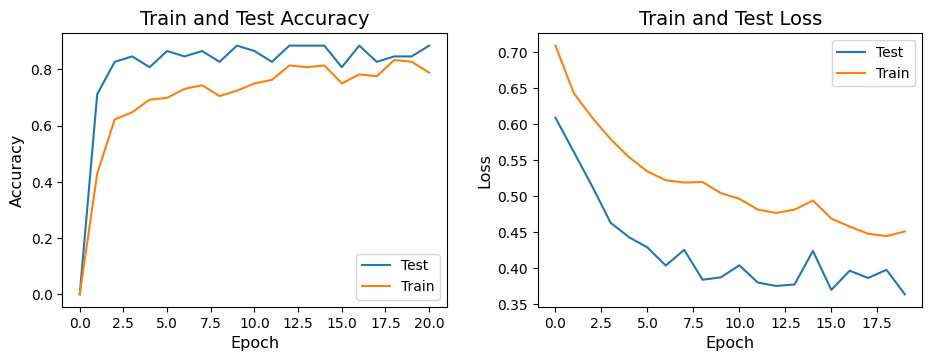

In [14]:
plot_metrics(metrics_history)

In [15]:
_, metrics_history, before, after = run(X_train=X_train, 
                                        y_train=y_train, 
                                        X_test=X_test, 
                                        y_test=y_test,
                                        batch_size=13,
                                        key=jax.random.key(42),
                                        input_dim=X_train.shape[1], 
                                        hidden=(60,15), 
                                        output_dim=2, 
                                        num_epochs=20)

[train] eposh: 0, loss: 0.702873945236206, accuracy: 52.56410217285156
[test] epoch: 0, loss: 0.62799471616745, accuracy: 69.23077392578125
[train] eposh: 1, loss: 0.6477232575416565, accuracy: 60.89743423461914
[test] epoch: 1, loss: 0.574553906917572, accuracy: 76.92308044433594
[train] eposh: 2, loss: 0.6089823246002197, accuracy: 63.4615364074707
[test] epoch: 2, loss: 0.49566134810447693, accuracy: 84.61538696289062
[train] eposh: 3, loss: 0.5646886825561523, accuracy: 69.23077392578125
[test] epoch: 3, loss: 0.422340452671051, accuracy: 80.76922607421875
[train] eposh: 4, loss: 0.5364355444908142, accuracy: 73.07691955566406
[test] epoch: 4, loss: 0.4198586642742157, accuracy: 86.53846740722656
[train] eposh: 5, loss: 0.5122776031494141, accuracy: 74.35897827148438
[test] epoch: 5, loss: 0.3945588171482086, accuracy: 86.53846740722656
[train] eposh: 6, loss: 0.5044112801551819, accuracy: 78.20512390136719
[test] epoch: 6, loss: 0.39525139331817627, accuracy: 86.53846740722656
[tr

accuracy
loss


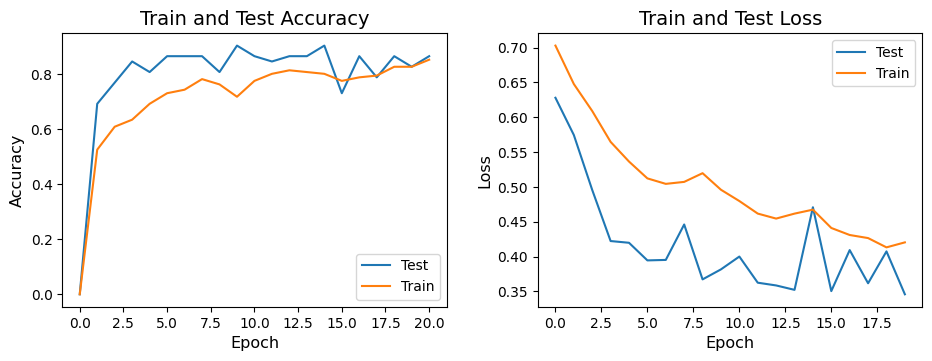

In [16]:
plot_metrics(metrics_history)